In [1]:
import numpy as np
from tqdm.notebook import tqdm

from neurodsp.sim import sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF
from bycycle import Bycycle

from ndspflow.core.workflow import WorkFlow

# WorkFlow Class

`WorkFlow` objects wrap analyses that are typically functionally oriented into a unified object. This provides reproducible analyses, a unified interface for a variety of DSP packages and models, and memory/computational efficiency. This class consist of three types of nodes:

1. __Input__ : Defines the raw input numpy array, including simulations, reading BIDS structure, or custom classes or functions to read in raw binary data.
    
2. __Transformations__ : Defines the order of preprocessing operations used to manipulate the raw array input. Any function that accepts an y-array, and returns an y-array, with or without an x-array, are supported. This allows interfacing of signal processing packages, such as `scipy`, `numpy`, `mne`, `neurodsp`, etc. Examples: filtering, re-referencing, ICA, frequency domain transformations, etc.

3. __Models__ : Defines the model class that is used to fit or extract values out of the transformed array. Models should be initialized and contain a `fit` method that accepts array definitions. Examples: `fooof`, `bycycle`.

__Forks__ : Forks refer to the splitting of the workflow into multiple streams. Forks may optionally have additional transforms (e.g. one model may want power spectra, whereas another requires time series).

## Initialization

When initializing a `WorkFlow` object, arbitary keyword arguments may be passed that are required by one of its sub-classes. In the case below, we want to set the seeds attributes, required by the `Simulation` sub-class accesed via the `.simulate()` method. X-axis values may be optionally defined here, if required by the model passed to the `.fit()` method.

In [2]:
# Settings
n_seconds = 10
fs = 1000
seeds=np.arange(4)

# Initialize
wf = WorkFlow(seeds=seeds)

## 1. Input
Next we define the input array, here a series of simulations. Multiple simulations calls may be stacked to create the input array. Any simulation function may be used as long as a single array is returned. The way arrays are combined are defined by the `operator` argument. The general form follows: 

`.simulate(func, *args, operator, **kwargs)`

In [3]:
# 1. Define np.array input
wf.simulate(sim_powerlaw, n_seconds, fs, exponent=-2)
wf.simulate(sim_oscillation, n_seconds, fs, freq=10, operator='add')
wf.simulate(sim_oscillation, n_seconds, fs, freq=20, operator='add')

## 2. Transform
The input array may transformed using any function, as long as a single array is returned. Transformation calls may also be stacked to define a series of transformations (e.g. pre-processing steps). The `axis` argument is used for ndarrays with greater than two dimensions and specifies which axis to iterate over to apply the transform. The general form follows: 

`.transform(func, *args, axis=None, **kwargs)`.

In [4]:
# 2. Transform input
wf.transform(filter_signal, fs, 'lowpass', 300, remove_edges=False)

## 3. Model

Up to this point, all sub-workflows share the same set of simulations (4 unique seeds) and the 300 Hz low-pass filter. The `.fork(index)` method is used to split the workflow into sub-workflows. The first `.fork(0)` called with a unique index argument creates a save state at the point of the call. Subsequent `.fork(0)` calls restore that state at the time of the inital `.fork` call before proceding. New fork calls (e.g. `.fork(1)`) creates a new save state that can be later restored upon subsequent calls of `.fork(1)`. In general, a unique index passed to `.fork(ind)` creates a new save state, and an existing index restores the corresponding save state at the time of the first call. Below, we fork the workflow into sub-flows that end on two sets of `FOOOF` and `Bycycle` models. Note that the `.fit()` calls belows does not run the workflow and instead adds fitting the model to the call stack. Once the `WorkFlow` is complete, the `.run()` method is used to execute the workflow, as shown in the next section.

In [5]:
# Create a fork that references the transform in the previous cell
wf.fork(0)

# All FOOOF sub-workflows share these transformations
wf.transform(filter_signal, fs, 'lowpass', 200, remove_edges=False)
wf.transform(compute_spectrum, fs)

# FOOOF sub-workflows
wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 100))

wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 200))

In [6]:
# Restore that state after the first filter, two code cells above
wf.fork(0)

# All Bycycle sub-workflows  share these transformations
wf.transform(filter_signal, fs, 'lowpass', 100, remove_edges=False)

# Bycycle sub-workflows
wf.fork(2)
wf.fit(Bycycle(), fs, (1, 100))

wf.fork(2)
wf.fit(Bycycle(), fs, (1, 200))

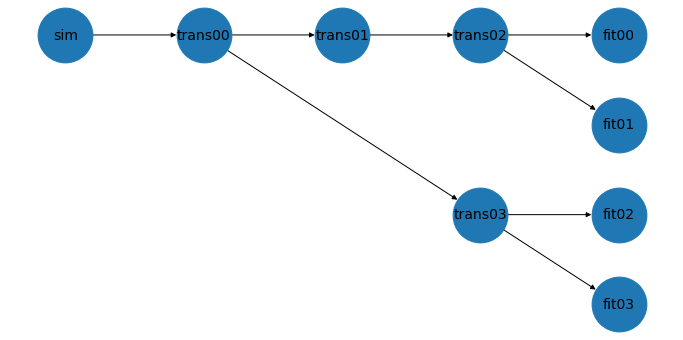

In [7]:
# Plot the workflow
wf.plot()

## Execute

Lastly, the `WorkFlow` is executed in parallel using the `run` method.  Results are accesible via the `.results` attirbute. The order of models in `.results` maintains the in the same order as the `WorkFlow` was defined. Here the first index of `.results` refers to the simulation seed (in order of `seeds` above) and the second index refers to the order of the `.fit` calls above.

In [8]:
# Execute workflow
wf.run(n_jobs=-1)

# Access results
wf.results

[[<fooof.objs.fit.FOOOF at 0x7f1d4171ee50>,

### Returning Model Attributes

The the `return_attrs` arguments is used to transfer any attribute in the model class (here a `FOOOF` and `Bycycle` object) to the `results` attribute of the `WorkFlow` class. This is more memory efficienct as copies of PSDs, time series, and all other model class attributes are not passed to the `results` attribute and are dropped from memory.

If `return_attrs` is a string or list of strings, these attribues are expected to exist in each model. A 2d list of `return_attrs` strings provides the greatest flexibility, pairing each list of attributes to each model.

In [9]:
# Execute workflow
return_attrs = [
    *[['peak_params_', 'aperiodic_params_', 'r_squared_']] * 2, # FOOOF attributes
    *[['time_peak', 'time_rdsym', 'monotonicity']] * 2          # Bycycle attributes
]

# Define attributes to extract from each model
return_attrs

[['peak_params_', 'aperiodic_params_', 'r_squared_'],
 ['peak_params_', 'aperiodic_params_', 'r_squared_'],
 ['time_peak', 'time_rdsym', 'monotonicity'],
 ['time_peak', 'time_rdsym', 'monotonicity']]

In [10]:
# Rerun the workflow
wf.run(return_attrs=return_attrs)

# This first index below reference the zeroth simulation.
# The second index reference the model
print(wf.results[0][0].keys())
print(wf.results[0][2].keys())

dict_keys(['peak_params_', 'aperiodic_params_', 'r_squared_'])
dict_keys(['time_peak', 'time_rdsym', 'monotonicity'])
